# Multi-Task Test
At first we have to install the newest version of fvGP

In [1]:
##first, install the newest version of fvgp
#!pip install fvgp~=4.6.0
#!pip install torch


## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import plotly.graph_objects as go
from itertools import product
import plotly.io as pio
pio.renderers.default = "png"
%load_ext autoreload
%autoreload 2

## Simple 1d Example

### Data

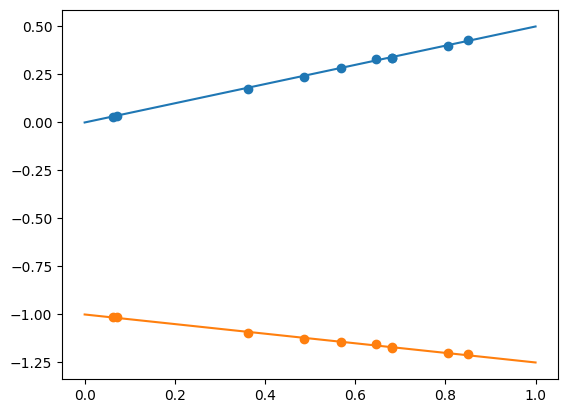

In [3]:
def f1(x): return 0.5 * x
def f2(x): return (-.25 * x) - 1.

x_pred1d = np.linspace(0,1,50)
plt.plot(x_pred1d,f1(x_pred1d))
plt.plot(x_pred1d,f2(x_pred1d))
x_data = np.random.rand(10)
y_data1 = f1(x_data) + np.random.uniform(low = -0.01, high = 0.01, size =len(x_data))
y_data2 = f2(x_data) + np.random.uniform(low = -0.01, high = 0.01, size =len(x_data))
plt.scatter(x_data,y_data1) 
plt.scatter(x_data,y_data2) 
plt.show()

### GP initialization

In [4]:
from fvgp import fvGP

my_gp2 = fvGP(x_data.reshape(len(x_data),1), np.column_stack([y_data1, y_data2]))
print("Global Training in progress")
my_gp2.train(max_iter = 20, info=True)




Global Training in progress
Finished  10  out of  20  MCMC iterations. f(x)=  40.80949222294407


/home/marcus/Coding/fvGP/fvgp/gp.py:247: UserWarning:

Hyperparameters initialized to a vector of ones.

/home/marcus/Coding/fvGP/fvgp/gp.py:291: UserWarning:

No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.

/home/marcus/Coding/fvGP/fvgp/gp.py:521: UserWarning:

Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions



array([0.53763267, 2.42322162, 1.3442452 ])

In [5]:
print(my_gp2.x_data)
print(my_gp2.y_data)

[[0.36253638 0.        ]
 [0.68172903 0.        ]
 [0.68186625 0.        ]
 [0.64542802 0.        ]
 [0.80561326 0.        ]
 [0.4868725  0.        ]
 [0.5676006  0.        ]
 [0.8508072  0.        ]
 [0.07120235 0.        ]
 [0.06207676 0.        ]
 [0.36253638 1.        ]
 [0.68172903 1.        ]
 [0.68186625 1.        ]
 [0.64542802 1.        ]
 [0.80561326 1.        ]
 [0.4868725  1.        ]
 [0.5676006  1.        ]
 [0.8508072  1.        ]
 [0.07120235 1.        ]
 [0.06207676 1.        ]]
[ 0.17692291  0.33481608  0.33738902  0.33232263  0.39936002  0.23699982
  0.28198528  0.43151973  0.0353161   0.02776516 -1.09721121 -1.17543219
 -1.1708483  -1.15455512 -1.20083541 -1.12989317 -1.14587126 -1.20383377
 -1.0155668  -1.01505819]


### Predictions

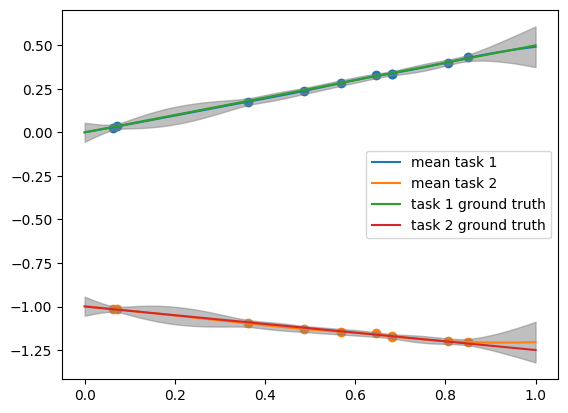

In [6]:
#mean and standard deviation
mean = my_gp2.posterior_mean(x_pred=x_pred1d.reshape(50,1))["m(x)"]
std = np.sqrt(my_gp2.posterior_covariance(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["v(x)"])


plt.plot(x_pred1d.reshape(50,1),mean[:,0], label = "mean task 1")
plt.plot(x_pred1d.reshape(50,1),mean[:,1], label = "mean task 2")
plt.scatter(x_data,y_data1) 
plt.scatter(x_data,y_data2) 
plt.plot(x_pred1d,f1(x_pred1d), label = "task 1 ground truth")
plt.plot(x_pred1d,f2(x_pred1d), label = "task 2 ground truth")
plt.fill_between(x_pred1d, mean[:,0] - 3. * std[:,0], mean[:,0] + 3. * std[:,0], alpha = 0.5, color = "grey")
plt.fill_between(x_pred1d, mean[:,1] - 3. * std[:,1], mean[:,1] + 3. * std[:,1], alpha = 0.5, color = "grey")
plt.legend()
plt.show()

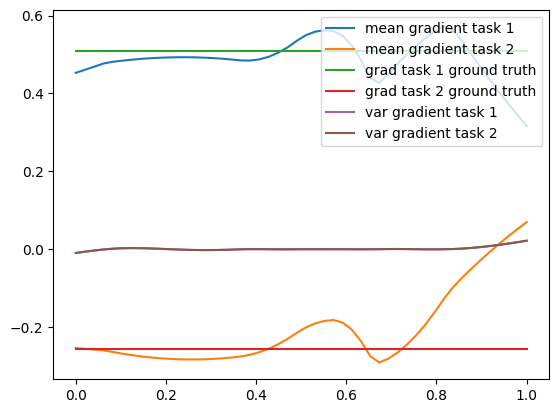

In [7]:
#mean gradient and variance gradient
mean_grad = my_gp2.posterior_mean_grad(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["dm/dx"]
var_grad = my_gp2.posterior_covariance_grad(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["dv/dx"]

plt.plot(x_pred1d.reshape(50,1),mean_grad[:,0,0], label = "mean gradient task 1")
plt.plot(x_pred1d.reshape(50,1),mean_grad[:,0,1], label = "mean gradient task 2")
plt.plot(x_pred1d,np.gradient(f1(x_pred1d), 1./50.), label = "grad task 1 ground truth")
plt.plot(x_pred1d,np.gradient(f2(x_pred1d), 1./50.), label = "grad task 2 ground truth")
plt.plot(x_pred1d.reshape(50,1),var_grad[:,0,0], label = "var gradient task 1")
plt.plot(x_pred1d.reshape(50,1),var_grad[:,0,1], label = "var gradient task 2")
plt.legend()
plt.show()

### What if some tasks are missing from the data

#### It works just fine, but we have to insert np.nan at positions of missing data, both for y and the variances. 

In [8]:
y_data = np.column_stack([y_data1, y_data2])
noise_variances = np.zeros(y_data.shape) + 0.01
y_data[2,0] = np.nan
noise_variances[2,0] = np.nan

y_data[6,1] = np.nan
noise_variances[6,1] = np.nan

my_gp2 = fvGP(x_data.reshape(len(x_data),1), y_data, noise_variances=noise_variances)
print("Global Training in progress")
my_gp2.train(max_iter = 20)

Global Training in progress


array([2.8776136 , 4.65381811, 3.00965522])

## 3d Example

### Data

In [9]:
data = np.load("./data/sim_variable_mod.npy")
sparsification = 32

x_data3 = data[:,5:][::sparsification]
y_data3 = data[:,0:3][::sparsification]

#it is good practice to check the format of the data
print(x_data3.shape)
print(y_data3.shape)

(198, 3)
(198, 3)


In [10]:
x = np.linspace(30,100,100)
y = np.linspace(40,130,100)
x_pred3D = np.asarray(list(product(x, y)))
x_pred3D = np.column_stack([x_pred3D, np.zeros((len(x_pred3D),1)) + 300.])

In [11]:
def scatter(x,y,z,size=3, color = 1):
    #if not color: color = z
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(color=color, size = size)))
    
    
    fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

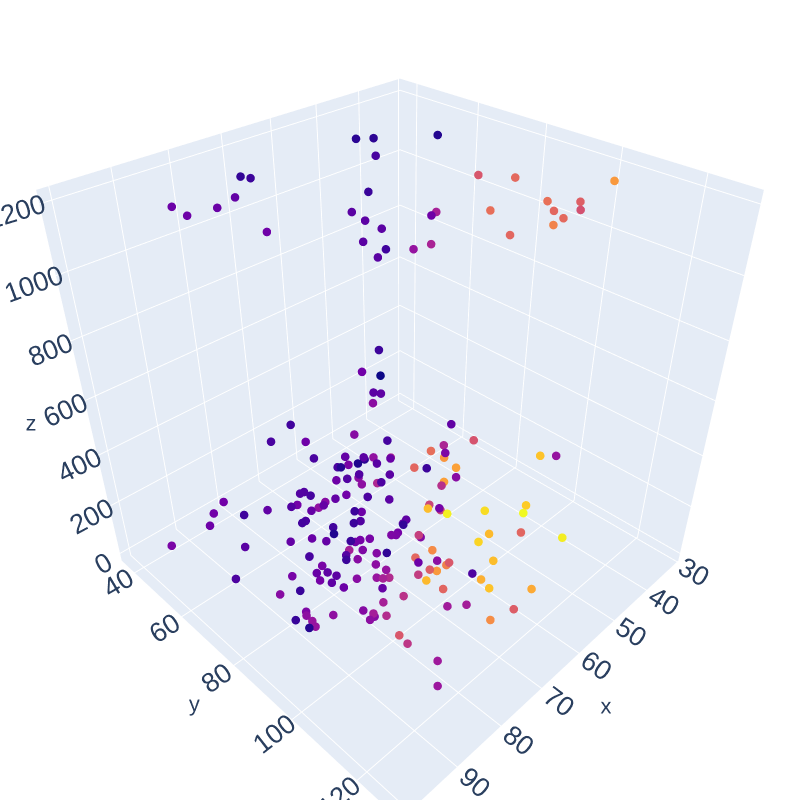

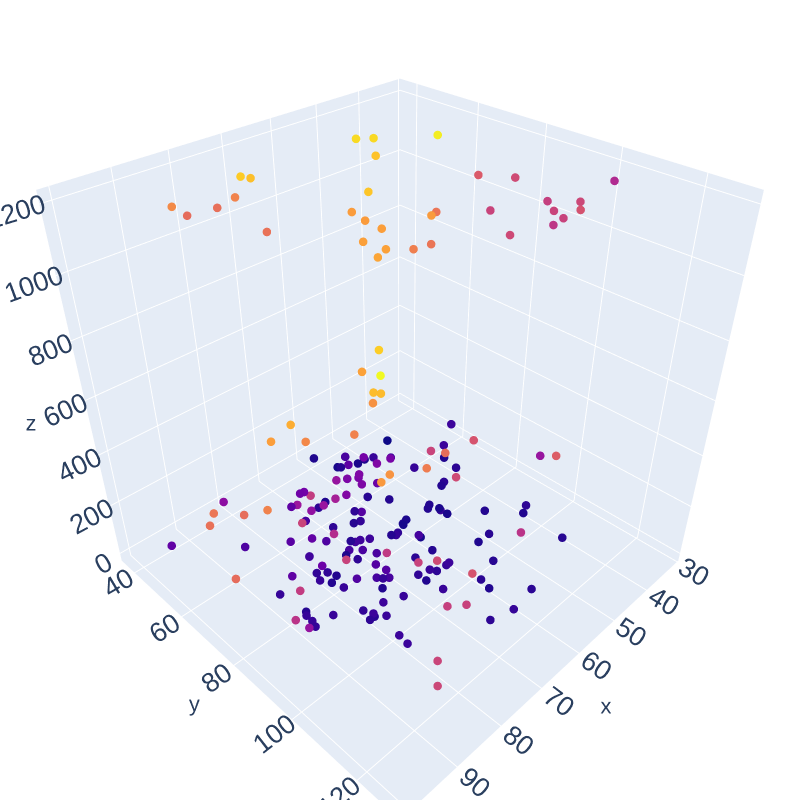

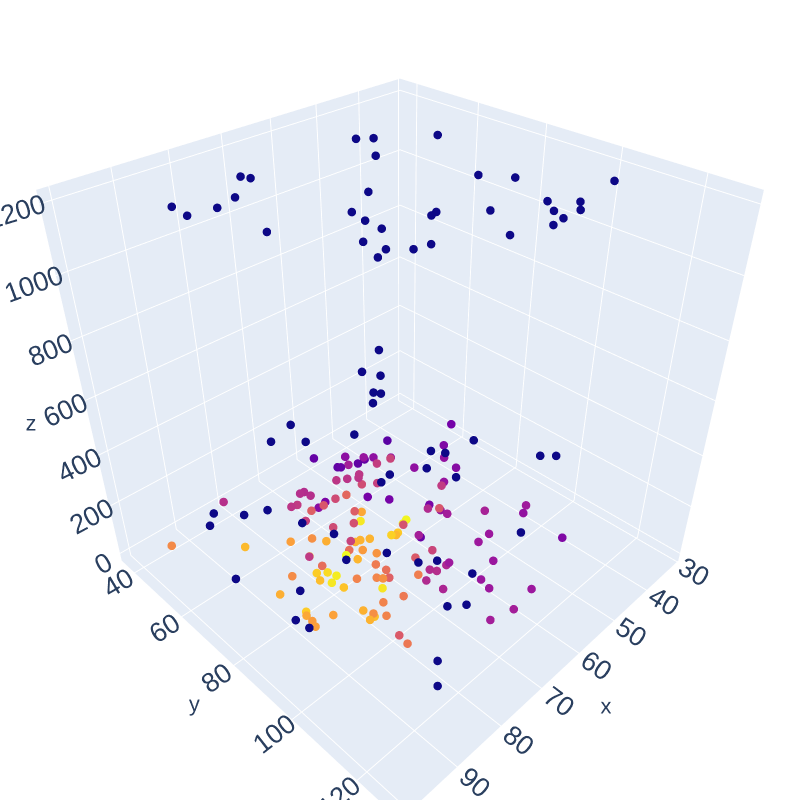

In [12]:
scatter(x_data3[:,0],x_data3[:,1],x_data3[:,2], size = 5, color = y_data3[:,0])
scatter(x_data3[:,0],x_data3[:,1],x_data3[:,2], size = 5, color = y_data3[:,1])
scatter(x_data3[:,0],x_data3[:,1],x_data3[:,2], size = 5, color = y_data3[:,2])

### Initialization

#### (a) Default behavior

In [13]:
from fvgp import fvGP

my_gp2 = fvGP(x_data3,y_data3)
print("Global Training in progress")
my_gp2.train(max_iter = 2)

Global Training in progress


/home/marcus/Coding/fvGP/fvgp/gp.py:247: UserWarning:

Hyperparameters initialized to a vector of ones.

/home/marcus/Coding/fvGP/fvgp/gp.py:291: UserWarning:

No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.

/home/marcus/Coding/fvGP/fvgp/gp.py:521: UserWarning:

Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions

/home/marcus/Coding/fvGP/fvgp/mcmc.py:105: RuntimeWarning:

overflow encountered in exp



array([3.26548263e-01, 3.87954315e+02, 8.30085583e+02, 8.40951765e+03,
       1.33343015e+01])

#### (b) Custom kernel
It is vital in the multi-task case to think hard about kernel design. The kernel is now a function
over X x X x T x T, where X is the input and T is the output space. Print the input of the kernel, it will have the dimensionality of this cartesian product space. 
The default kernel in fvgp is just a Matern kernel operating in this new space.

In [14]:
#A simple kernel that won't lead to good performance because it's stationary
from fvgp.kernels import *
def mkernel(x1,x2,hps):
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])

In [15]:
my_gp2 = fvGP(x_data3,y_data3,
              init_hyperparameters=np.ones((2)), kernel_function=mkernel
             )
print("MCMC Training in progress")


bounds = np.array([[0.01,1.],[0.01,1.]])
my_gp2.train(hyperparameter_bounds=bounds,max_iter = 20)

MCMC Training in progress


array([0.58730251, 0.89376175])

#### (c) A custom deep kernel

In [16]:
from fvgp.deep_kernel_network import *
iset_dim = 4
gp_deep_kernel_layer_width = 5
n = Network(iset_dim, gp_deep_kernel_layer_width)
print(n.number_of_hps)

def deep_multi_task_kernel(x1, x2, hps):  # pragma: no cover
    signal_var = hps[0]
    length_scale = hps[1]
    hps_nn = hps[2:]
    w1_indices = np.arange(0, gp_deep_kernel_layer_width * iset_dim)
    last = gp_deep_kernel_layer_width * iset_dim
    w2_indices = np.arange(last, last + gp_deep_kernel_layer_width ** 2)
    last = last + gp_deep_kernel_layer_width ** 2
    w3_indices = np.arange(last, last + gp_deep_kernel_layer_width * iset_dim)
    last = last + gp_deep_kernel_layer_width * iset_dim
    b1_indices = np.arange(last, last + gp_deep_kernel_layer_width)
    last = last + gp_deep_kernel_layer_width
    b2_indices = np.arange(last, last + gp_deep_kernel_layer_width)
    last = last + gp_deep_kernel_layer_width
    b3_indices = np.arange(last, last + iset_dim)

    n.set_weights(hps_nn[w1_indices].reshape(gp_deep_kernel_layer_width, iset_dim),
                  hps_nn[w2_indices].reshape(gp_deep_kernel_layer_width, gp_deep_kernel_layer_width),
                  hps_nn[w3_indices].reshape(iset_dim, gp_deep_kernel_layer_width))
    n.set_biases(hps_nn[b1_indices].reshape(gp_deep_kernel_layer_width),
                 hps_nn[b2_indices].reshape(gp_deep_kernel_layer_width),
                 hps_nn[b3_indices].reshape(iset_dim))
    x1_nn = n.forward(x1)
    x2_nn = n.forward(x2)
    d = get_distance_matrix(x1_nn, x2_nn)
    k = signal_var * matern_kernel_diff1(d, length_scale)
    return k


my_gp2 = fvGP(x_data3,y_data3,
              init_hyperparameters=np.ones((n.number_of_hps+2)), kernel_function=deep_multi_task_kernel
             )
print("Global Training in progress")


bounds = np.zeros((n.number_of_hps+2,2))
bounds[0] = np.array([0.1,10.])
bounds[1] = np.array([0.1,10.])
bounds[2:] = np.array([0.01,1])
my_gp2.train(hyperparameter_bounds=bounds,max_iter = 4, method="global", info = True)

79
Global Training in progress


/home/marcus/Coding/fvGP/fvgp/gp.py:291: UserWarning:

No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.



differential_evolution step 1: f(x)= -7.711717131778414
differential_evolution step 2: f(x)= -32.79677263067208
differential_evolution step 3: f(x)= -32.79677263067208
differential_evolution step 4: f(x)= -47.451019139719506


array([0.1109521 , 2.06599503, 0.19354269, 0.03222473, 0.59039749,
       0.43599338, 0.17443147, 0.80240984, 0.11731545, 0.18659212,
       0.46481112, 0.98184294, 0.80353168, 0.9165965 , 0.01477781,
       0.69105737, 0.57835472, 0.5522997 , 0.06835019, 0.77347266,
       0.92898601, 0.8940712 , 0.20182695, 0.7871879 , 0.66320756,
       0.79040684, 0.57164864, 0.30409247, 0.1401901 , 0.49688008,
       0.6593894 , 0.41574524, 0.45156297, 0.58663322, 0.33946198,
       0.82800359, 0.28689337, 0.20926209, 0.26060354, 0.99864926,
       0.23204363, 0.69041626, 0.52425746, 0.4518359 , 0.26432406,
       0.25721567, 0.52252217, 0.88094703, 0.22279913, 0.84108993,
       0.52316372, 0.29174574, 0.49401566, 0.68446284, 0.5567187 ,
       0.78612254, 0.50473006, 0.70986368, 0.14341475, 0.47571428,
       0.09225462, 0.51405384, 0.3053258 , 0.59981642, 0.83145107,
       0.36105243, 0.50693703, 0.57805044, 0.41957375, 0.84599141,
       0.61112771, 0.51465293, 0.53085652, 0.15587102, 0.50382

### Prediction

In [17]:
#first task
mean1 = my_gp2.posterior_mean(x_pred3D, x_out = np.zeros((1)))["m(x)"]
var1 =  my_gp2.posterior_covariance(x_pred3D, x_out = np.zeros((1)))["v(x)"]

#second task
mean2 = my_gp2.posterior_mean(x_pred3D, x_out = np.zeros((1)) + 1)["m(x)"]
var2 =  my_gp2.posterior_covariance(x_pred3D, x_out = np.zeros((1))+1)["v(x)"]

#third task
mean3 = my_gp2.posterior_mean(x_pred3D, x_out = np.zeros((1)) + 2)["m(x)"]
var3 =  my_gp2.posterior_covariance(x_pred3D, x_out = np.zeros((1))+2)["v(x)"]

##we could have also called for all tasks
#mean = my_gp2.posterior_mean(x_pred3D, x_out = np.array([0,1,2]))["f(x)"]
#var =  my_gp2.posterior_covariance(x_pred3D, x_out = np.array([0,1,2]))["v(x)"]

In [18]:
#extract data point to compare to:
index300 = np.where(x_data3[:,2]==300.)
imageX_data = x_data3[index300]
imageY_data = y_data3[index300]
#print(y_data3)

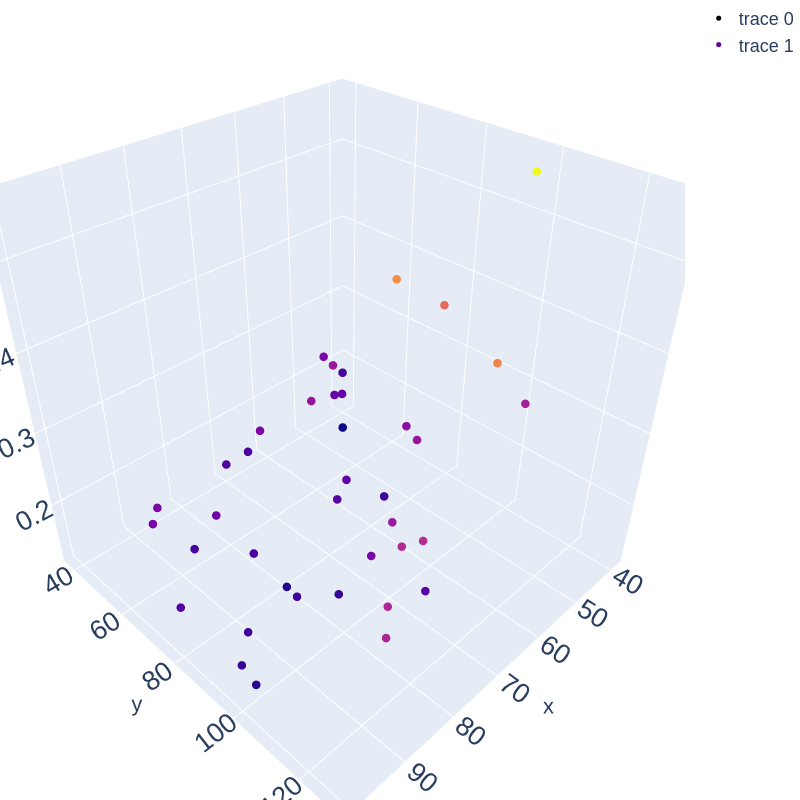

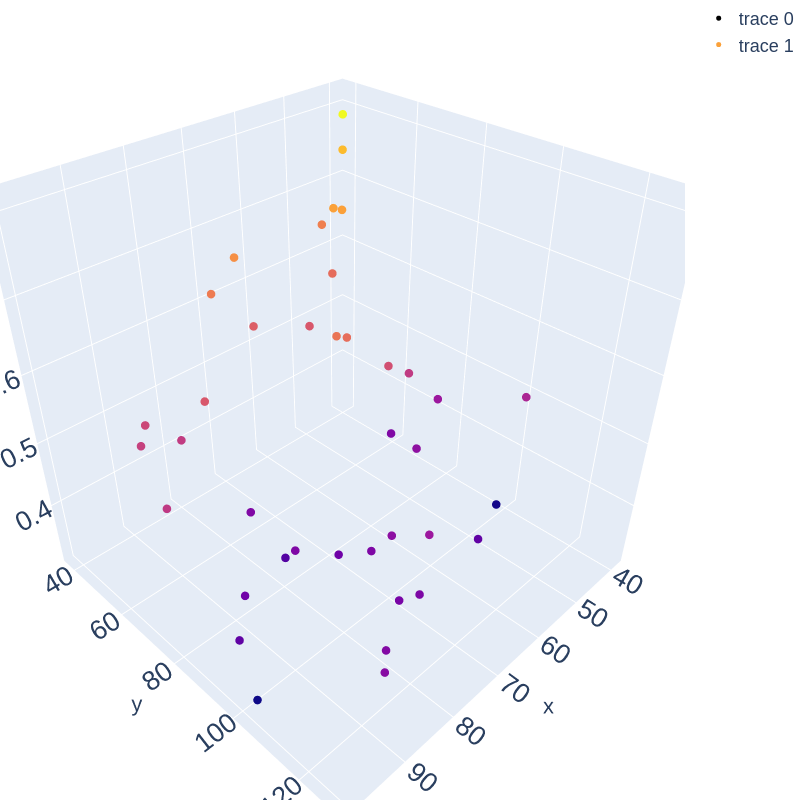

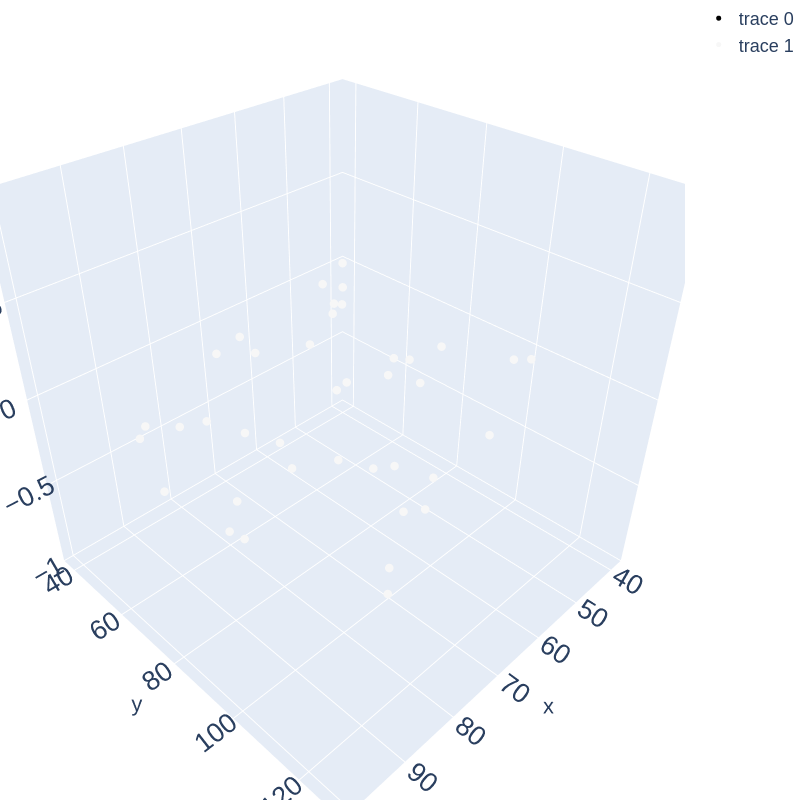

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0],y=x_pred3D[:,1], z=mean1,
                             mode='markers',marker=dict(color=mean1, size = 5)))
fig.add_trace(go.Scatter3d(x=imageX_data[:,0], y=imageX_data[:,1] , z=imageY_data[:,0],
                           mode='markers',marker=dict(color=imageY_data[:,0], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()



fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0], y=x_pred3D[:,1], z=mean2,
                           mode='markers',marker=dict(color=mean2, size = 5)))
fig.add_trace(go.Scatter3d(x=imageX_data[:,0], y=imageX_data[:,1], z=imageY_data[:,1],
                           mode='markers',marker=dict(color=imageY_data[:,1], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0], y=x_pred3D[:,1], z=mean3,
                           mode='markers',marker=dict(color=mean3, size = 5)))
fig.add_trace(go.Scatter3d(x=imageX_data[:,0], y=imageX_data[:,1], z=imageY_data[:,2],
                           mode='markers',marker=dict(color=imageY_data[:,2], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

